이 자료는 위키독스 딥 러닝을 이용한 자연어 처리 입문의 한국어 스팀 리뷰 감성 분석 튜토리얼입니다.  
이 자료는 2021년 10월 9일에 마지막으로 테스트되었습니다.

링크 : https://wikidocs.net/94748

## **10-08 BiLSTM으로 한국어 스팀 리뷰 감성 분류하기**
---

게임 플랫폼 스팀에 등록된 한국어 리뷰에 대해서 감성 분석을 진행해보겠습니다. 이 데이터는 긍정인 리뷰에는 레이블 1이, 부정인 리뷰에는 레이블 0이 부여되어져 있습니다. 앞서 진행했던 감성 분류 문제들과 마찬가지로 이진 분류 문제를 풉니다.

---
### **1. BiLSTM을 텍스트 분류에 사용하기**

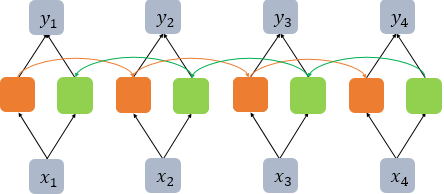

양방향 LSTM은 두 개의 독립적인 LSTM 아키텍처를 함께 사용하는 구조입니다. 위 그림에서 주황색 LSTM 셀은 순차적으로 입력을 받습니다. 자연어 처리라고 한다면, 마치 사람처럼 문장을 왼쪽 단어부터 순차적으로 읽는 셈입니다. 양방향 LSTM은 뒤의 문맥까지 고려하기 위해서 문장을 오른쪽에서 반대로 읽는 역방향의 LSTM 셀(위 그림에서 초록색)을 함께 사용합니다. 이 두 가지 정보를 고려하여 출력층에서 예측 시에 두 가지 정보를 모두 사용합니다.

위 그림은 다 대 다(many-to-many) 문제를 푸는 경우의 양방향 LSTM을 보여주고 있습니다. 그런데 양방향 LSTM을 다 대 일(many-to-one) 문제인 텍스트 분류 문제에 사용한다고 하면, 한 가지 의문이 생깁니다.

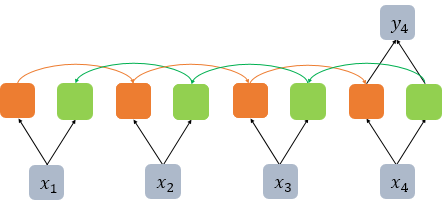

일반적으로 순방향 LSTM은 마지막 시점의 은닉 상태를 출력층으로 보내서 텍스트 분류를 수행합니다. 그렇다면 역방향 LSTM도 순방향과 같은 시점의 은닉 상태를 사용하면 될까요? 위 그림과 같이 텍스트 분류를 진행하는 경우, 역방향 LSTM은 $x_{4}$
만 본 상태입니다. 이 경우 역방향 LSTM이 텍스트 분류를 위한 유용한 정보를 갖고 있다고 기대하기 어렵습니다.

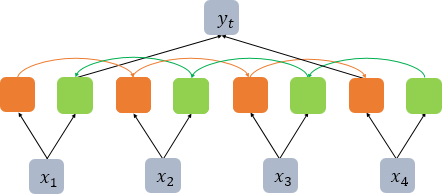

그래서 케라스에서는 양방향 LSTM을 사용하면서 return_sequences=False를 택할 경우에는 위의 그림과 같이 동작하고 있습니다. 순방향 LSTM의 경우에는 마지막 시점의 은닉 상태를 반환하고, 역방향 LSTM의 경우에는 첫번째 시점의 은닉 상태를 반환합니다. 위 구조를 통해서 양방향 LSTM으로 텍스트 분류를 수행할 수 있습니다.

케라스에서는 양방향 LSTM을 사용하면서 return_sequences=False를 택할 경우에는 아래의 링크와 같이 동작합니다.  

https://wikidocs.net/images/page/94748/bilstm3.PNG

---
### **2. Colab에 Mecab 설치**
여기서는 형태소 분석기 Mecab을 사용합니다. 저자의 경우 Mecab을 편하게 사용하기 위해서 구글의 Colab을 사용하였습니다. 참고로 Colab에서 실습하는 경우가 아니라면 아래의 방법으로 Mecab이 설치되지 않습니다. 이 경우 해당 환경에 맞게 Mecab을 설치하시거나 다른 형태소 분석기를 사용하시기 바랍니다.

In [1]:
# Colab에 Mecab 설치
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 25.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.8/588.8 kB 7.7 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1232 sha256=aa4844518c135c9e81e2021a2a612c8ba95b7fadb75465826eaac930be31db26
  Stored in directory: /root/.cache/pip/wheels/a0/56/2c/eac72592ca2e80bdc46ff47d1fb327629e2a24e8cdc5aaf95f
Successfully built mecab-python
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  1020k      0  0:00:01  0:00:01 --:--:-- 5037k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example/examp

In [2]:
# # Colab에 Mecab 설치
# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# %cd Mecab-ko-for-Google-Colab
# !bash install_mecab-ko_on_colab190912.sh

---
### **3. 스팀 리뷰 데이터에 대한 이해와 전처리**

다운로드 링크 : https://github.com/bab2min/corpus/tree/master/sentiment

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#### **1) 데이터 로드하기**

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")

('steam.txt', <http.client.HTTPMessage at 0x7c782e96ce10>)

해당 데이터에는 열제목이 별도로 없습니다. 그래서 임의로 두 개의 열제목인 'label'과 'reviews'를 추가해주겠습니다.

In [5]:
total_data = pd.read_table('steam.txt', names=['label', 'reviews'])
print('전체 리뷰 개수 :', len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 100000


총 10만개의 샘플이 존재합니다. 상위 5개의 샘플만 출력해봅시다.

In [6]:
total_data[:10]

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요
5,1,역시 재미있네요 전작에서 할수 없었던 자유로운 덱 빌딩도 좋네요^^
6,1,재미있었습니다.
7,1,은근 쉽지만 은근 어려운 게임
8,0,베ㅈ스다 이 개^ㅐ끼들아. 시작할 때 체스판 돌아가는거 5분동안 3번 봤더나 ㅈㄴ ...
9,1,1시간 40분동안 스트레스 다 풀림 ㄹㅇ


각 열에 대해서 중복을 제외한 샘플의 수를 카운트합니다.

In [7]:
total_data['reviews'].nunique(), total_data['label'].nunique()

(99892, 2)

reviews열에서 중복을 제외한 경우 99,892개입니다. 현재 10만개의 리뷰가 존재하므로 이는 현재 갖고 있는 데이터에 중복인 샘플들이 있다는 의미입니다. 중복인 샘플들을 제거해줍니다.

In [8]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 99892


NULL 값 유무를 확인합니다.

In [9]:
print(total_data.isnull().values.any())

False


#### **2) 훈련 데이터와 테스트 데이터 분리하기**
훈련 데이터와 테스트 데이터를 3:1 비율로 분리합니다.

In [10]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 74919
테스트용 리뷰의 개수 : 24973


훈련용 리뷰의 경우 약 7만 5,000개. 테스트용 리뷰의 경우 약 2만 5,000개가 존재합니다.

#### **3) 레이블의 분포 확인**
훈련 데이터의 레이블의 분포를 확인해봅시다.

<Axes: xlabel='label'>

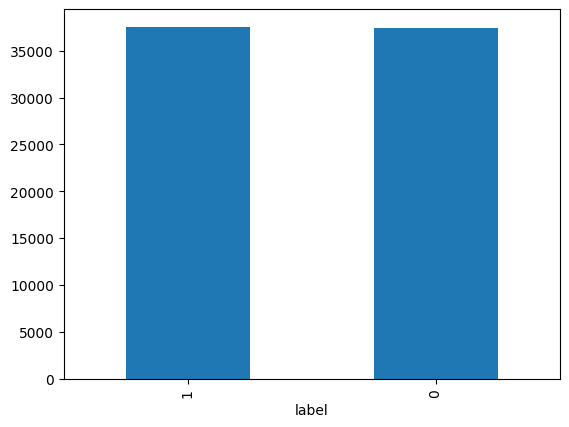

In [11]:
train_data['label'].value_counts().plot(kind = 'bar')

In [12]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  37376
1      1  37543


두 레이블 모두 약 3만 7천개로 50:50 비율을 가지고 있습니다.

#### **4) 데이터 정제하기**
정규 표현식을 사용하여 한글을 제외하고 모두 제거해줍니다. 또한 혹시 이 과정에서 빈 샘플이 생기지는 않는지 확인합니다.

In [13]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

label      0
reviews    0
dtype: int64


<ipython-input-13-5c91c21161d5>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['reviews'].replace('', np.nan, inplace=True)


테스트 데이터에 대해서도 같은 과정을 거칩니다.

In [14]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 24973


<ipython-input-14-5968a3f5f2bc>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경


불용어를 정의해줍니다.

In [15]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

#### **5) 토큰화**
형태소 분석기 Mecab을 사용하여 토큰화 작업을 수행합니다.

In [16]:
from konlpy.tag import Mecab
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [17]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [18]:
train_data

,label,reviews,tokenized
17152,1,게임 클리어 할 때까지 계속 새롭고 질리지 않습니다 정말 잘 만든 퍼즐 게임입니다 ...,"[클, 리어, 할, 때, 까지, 계속, 새롭, 질리, 않, 습니다, 정말, 잘, 만..."
59872,0,1편 나름 재밌게 했으면 그걸로 멈추는게 좋았네....,"[1, 편, 나름, 재밌, 했, 으면, 그걸로, 멈추, 좋, 았, ., ...]"
40613,0,할거 드럽게 없음,"[할, 거, 드럽, 없]"
80196,0,GFWL ㅈ까라. 이건 그거 하나만으로도 살 가치가 없는 겜. 내가 저거 때문에 이...,"[GFWL, ㅈ, 까라, ., 이건, 그거, 하나, 으로, 살, 가치, 없, ., ..."
35283,0,돈 아깝다.,"[돈, 아깝, .]"
...,...,...,...
6265,1,이쯤되면 생존자가 살인마,"[쯤, 생존자, 살인마]"
54920,1,시간때우기 매우좋은 게임. 특히 군사전략게임을 좋아한다면 한번 해보는것을 추천한다.,"[시간, 때우, 기, 매우, 좋, ., 특히, 군사, 전략, 좋, 아, 한다면, 번..."
76885,1,스팀에 출시돼고 나서야 알게되었지만. 지금이라도 알게돼 다행이다. 나는 비시즈를 좋...,"[스팀, 출시, 돼, 나서, 야, 알, 었, 지만, ., 지금, 라도, 알, 돼, ..."
860,0,점프도 어렵고 금방 끝남,"[점프, 어렵, 금방, 끝, 남]"


Counter()를 사용하여 각 단어에 대한 빈도수를 카운트합니다. 우선 부정 리뷰에 대해서 빈도수가 높은 상위 20개 단어들을 출력합니다.

In [19]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [20]:
print(negative_words[:20])
print(positive_words[:20])

['1' '편' '나름' '재밌' '했' '으면' '그걸로' '멈추' '좋' '았' '.' '...' '할' '거' '드럽' '없'
 'GFWL' 'ㅈ' '까라' '.']
['클' '리어' '할' '때' '까지' '계속' '새롭' '질리' '않' '습니다' '정말' '잘' '만든' '퍼즐' '입니다'
 '추천' '합니다' '어쌔신' '크리드' '다른']


In [21]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[(np.str_('.'), 36401), (np.str_('안'), 8137), (np.str_('없'), 7140), (np.str_('는데'), 5743), (np.str_('있'), 5688), (np.str_('..'), 5158), (np.str_(','), 4692), (np.str_('같'), 4249), (np.str_('로'), 4174), (np.str_('?'), 4139), (np.str_('할'), 3917), (np.str_('거'), 3915), (np.str_('나'), 3840), (np.str_('해'), 3670), (np.str_('너무'), 3519), (np.str_('기'), 3355), (np.str_('으로'), 3352), (np.str_('했'), 3277), (np.str_('어'), 3159), (np.str_('습니다'), 2957)]


긍정 리뷰에 대해서도 동일하게 출력해봅시다.

In [22]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[(np.str_('.'), 36364), (np.str_('있'), 9980), (np.str_('좋'), 6544), (np.str_('!'), 5894), (np.str_(','), 5394), (np.str_('습니다'), 5161), (np.str_('재밌'), 4996), (np.str_('할'), 4853), (np.str_('지만'), 4689), (np.str_('해'), 4379), (np.str_('없'), 4153), (np.str_('로'), 3913), (np.str_('으로'), 3901), (np.str_('보'), 3848), (np.str_('수'), 3830), (np.str_('는데'), 3782), (np.str_('기'), 3599), (np.str_('..'), 3478), (np.str_('안'), 3379), (np.str_('것'), 3368)]


두 가지 경우에 대해서 각각 길이 분포를 확인해봅시다.

긍정 리뷰의 평균 길이 : 17.333723996484032
부정 리뷰의 평균 길이 : 17.591770119863014


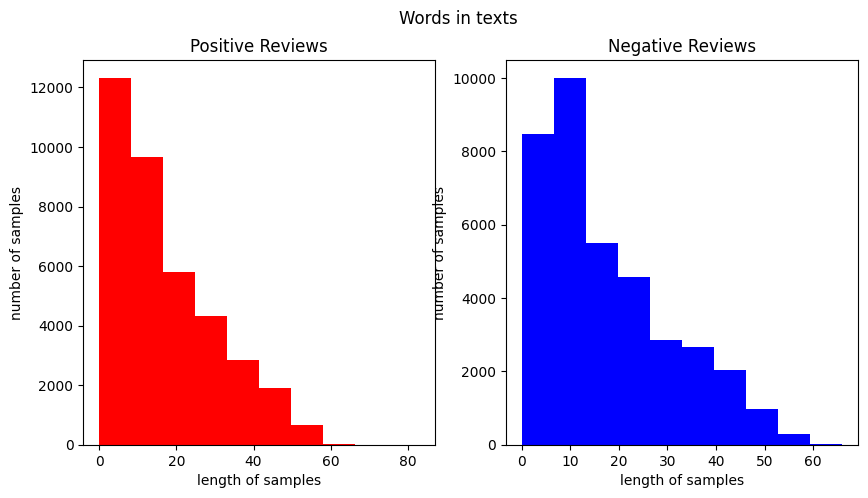

In [23]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

유의미한 차이가 있는 것 같지는 않습니다.

In [24]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test = test_data['tokenized'].values
y_test = test_data['label'].values

#### **7) 정수 인코딩**
기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 합니다. 우선, 훈련 데이터에 대해서 단어 집합(vocaburary)을 만들어봅시다.

In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)  # 단어사전 만들기

단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었습니다. 이는 tokenizer.word_index를 출력하여 확인 가능합니다. 등장 횟수가 1회인 단어들은 자연어 처리에서 배제하고자 합니다. 이 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

In [26]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 37464
등장 빈도가 1번 이하인 희귀 단어의 수: 16606
단어 집합에서 희귀 단어의 비율: 44.325218876788384
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.2693098519418775


단어가 약 32,000개가 존재합니다. 등장 빈도가 threshold 값인 2회 미만. 즉, 1회인 단어들은 단어 집합에서 약 42%를 차지합니다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 매우 적은 수치인 약 1.2%밖에 되지 않습니다. 아무래도 등장 빈도가 1회인 단어들은 자연어 처리에서 별로 중요하지 않을 듯 합니다. 그래서 이 단어들은 정수 인코딩 과정에서 배제시키겠습니다. 등장 빈도수가 1인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한하겠습니다.

In [27]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 20860


단어 집합의 크기는 18,941개입니다. 이를 토크나이저의 인자로 넘겨주면, 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환합니다. 이러한 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환하겠습니다.

In [28]:
vocab_size

20860

In [29]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)  # X_train으로 만든 tokenizer활용!

정수 인코딩이 진행되었는지 확인하고자 X_train과 X_test에 대해서 상위 3개의 샘플만 출력합니다.

In [30]:
print(X_train[:3])

[[496, 670, 9, 40, 95, 168, 2594, 641, 31, 11, 78, 54, 256, 122, 44, 52, 60], [47, 170, 326, 23, 26, 72, 3790, 1046, 8, 65, 2, 90], [9, 21, 1564, 5]]


In [31]:
print(X_test[:3])

[[774, 39, 20, 472, 60, 2, 116, 150, 103, 6898, 527], [4811, 732, 882, 757, 730, 125, 5, 1892, 109, 406, 3729, 84, 600, 2024, 4572, 285, 188, 69, 30, 395, 40, 95, 1037, 24, 6719, 6855], [1883, 849, 585, 56, 28, 2, 385]]


#### **8) 패딩**
서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행해보겠습니다. 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 알아보겠습니다.

리뷰의 최대 길이 : 83
리뷰의 평균 길이 : 17.46245945621271


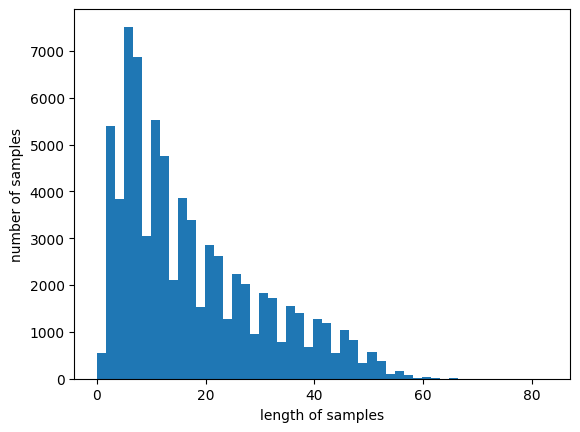

In [32]:
print('리뷰의 최대 길이 :', max(len(l) for l in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

리뷰의 최대 길이는 64, 평균 길이는 약 15입니다. 그래프로 봤을 때, 전체적으로는 60이하의 길이를 가지는 것으로 보입니다.

In [33]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

최대 길이가 64이므로 만약 60으로 패딩할 경우, 몇 개의 샘플들을 온전히 보전할 수 있는지 확인합니다.

In [34]:
max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.93993512994034


훈련용 리뷰의 99.99%가 60이하의 길이를 가집니다. 훈련용 리뷰를 길이 60으로 패딩하겠습니다.

In [35]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [36]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  496,
        670,    9,   40,   95,  168, 2594,  641,   31,   11,   78,   54,
        256,  122,   44,   52,   60], dtype=int32)

---
### **4. BiLSTM으로 스팀 리뷰 감성 분류하기**
하이퍼파라미터, EarlyStopping과 ModelCheckpoint와 같은 모델에 대한 상세 코드는 네이버 영화 리뷰 분류와 네이버 쇼핑 리뷰 분류 때와 크게 다르지 않습니다. 하지만 이번에는 양방향 LSTM을 사용했다는 점에서 앞선 실습들과 차이를 보입니다. LSTM이 Bidirectional( ) 안에 기재되었다는 사실에 주목합시다.

In [37]:
import re

In [38]:
from tensorflow.keras.layers import Embedding, Dense, GRU, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [39]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(Bidirectional(GRU(100)))
model.add(Dense(1, activation='sigmoid'))

In [40]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('BiLSTM_best_model.keras', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [41]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.6112 - loss: 0.6448
Epoch 1: val_acc improved from -inf to 0.72197, saving model to BiLSTM_best_model.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - acc: 0.6115 - loss: 0.6445 - val_acc: 0.7220 - val_loss: 0.5529
Epoch 2/15
231/235 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.7617 - loss: 0.4989
Epoch 2: val_acc improved from 0.72197 to 0.76989, saving model to BiLSTM_best_model.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - acc: 0.7619 - loss: 0.4986 - val_acc: 0.7699 - val_loss: 0.4958
Epoch 3/15
233/235 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.8003 - loss: 0.4399
Epoch 3: val_acc improved from 0.76989 to 0.78784, saving model to BiLSTM_best_model.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - acc: 0.8003 - loss: 0.4399 - val_acc: 0.7878 - val_loss: 0.4641
Epoch 4/15
233/235 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.8132 - loss: 0.4172
Epoch 4: val_acc improved from 0.78784 to 0.78837, saving model to BiLSTM_bes

저자의 경우 에포크 7에서 조기 종료가 발생했습니다.

In [42]:
loaded_model = load_model('BiLSTM_best_model.keras')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

781/781 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - acc: 0.7811 - loss: 0.4644
테스트 정확도: 0.7844


---
### **5. 리뷰 예측해보기**

임의의 문장에 대한 예측을 위해서는 학습하기 전 전처리를 동일하게 적용해줍니다.

In [43]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [44]:
sentiment_predict('노잼 ..완전 재미 없음 ㅉㅉ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
90.80% 확률로 부정 리뷰입니다.


<ipython-input-43-53fd1a88dada>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


In [45]:
sentiment_predict('유일하게 어벤져스 시리즈중에 엔딩 안본 게임이다. 돈버린 느낌')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
50.54% 확률로 긍정 리뷰입니다.


<ipython-input-43-53fd1a88dada>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


In [46]:
sentiment_predict('조금 어렵지만 재밌음ㅋㅋ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
98.12% 확률로 긍정 리뷰입니다.


<ipython-input-43-53fd1a88dada>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


In [47]:
sentiment_predict('케릭터가 예뻐서 좋아요')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
89.43% 확률로 긍정 리뷰입니다.


<ipython-input-43-53fd1a88dada>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측
